Your Name and PRN:
- Name : Anurag Sahu
- PRN  : 250840128011
- Date : 13 Nov 2025 

In [1]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.datasets import make_moons
from sklearn.model_selection import  train_test_split # Import function to split dataset into training and testing subsets
from sklearn.metrics import * # Import function to calculate various metric

In [ ]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input'
inpDir = Path('.') / '..' / 'input'
# outDir = '../output'
outDir = Path('.') / 'output'

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)  # Set Random Seed for reproducible  results
rng = np.random.default_rng(RANDOM_STATE)

TEST_SIZE = 0.2  # Size of test data
NOISE = 0.2
EPOCHS = 100
ALPHA = 0.01  # Learning Rate
N_SAMPLE = 1000  #

# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium'
          }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid')  # plt.style.use('ggplot')

In [5]:
def fn_plot_decision_boundary(x: np.ndarray, wts: np.ndarray, pred_func):
    """
    Plots the decision boundary for a classification model along with the data points.

    Args:
        x (np.ndarray): Input feature matrix with shape (n_samples, 3)
        wts (np.ndarray): Weights matrix
        pred_func: Function to predict using weights and datapoints
    """

    # Initialize the figure with specified dimensions
    fig, ax = plt.subplots(figsize=(8, 5))

    # Small increment value to create a fine grid for smooth decision boundary
    dm = 0.05
    padding = 2 * dm

    # Calculate the range for x-axis (first feature) with padding
    x_min, x_max = x[:, 0].min() - padding, x[:, 0].max() + padding

    # Calculate the range for y-axis (second feature) with padding
    y_min, y_max = x[:, 1].min() - padding, x[:, 1].max() + padding

    # Create a mesh grid covering the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))

    # Flatten the mesh grid arrays and stack them column-wise to create coordinate pairs
    XX = np.c_[xx.ravel(), yy.ravel()]  # Resulting shape: (n_points, 2)

    # Add a column of ones to the coordinate array for the bias term
    XX = np.hstack((XX, np.ones((XX.shape[0], 1))))  # make array compatible

    # List to collect predictions for each point in the mesh grid
    y_pred = []

    # Iterate over each coordinate point in the mesh grid
    for row in XX:
        # Make prediction for the current coordinate using global 'weights' and 'predict' function
        y_p = pred_func(row, wts)
        y_pred.append(y_p)

    # Reshape predictions to match the original mesh grid dimensions
    Z = np.array(y_pred).reshape(xx.shape)

    # Create filled contour plot showing the decision regions
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)

    # Scatter plot of the actual data points, colored by their true class labels
    ax.scatter(x[:, 0], x[:, 1], c=x[:, 2], s=20, edgecolor='k', cmap=plt.cm.bwr)

    # Set plot title and axis labels
    ax.set_title('Decision Boundary')
    ax.set_xlabel('A')
    ax.set_ylabel('B')

    # Display the final plot
    plt.show()

In [ ]:
X,y= make_moons(1000,noise = NOISE,random_state=RANDOM_STATE,shuffle=True)
X.shape,y.shape

((1000, 2), (1000,))

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=TEST_SIZE,random_state=RANDOM_STATE,stratify=y)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [33]:
def fun_sigmoid(z):
    return 1/(1+np.exp(-z))

def fun_activ(z):
    return np.tanh(z)

def fun_activ_prime(z):
    return 1.0 - np.tanh(z)**2

In [45]:
def preddict(model,x):
    W1 = model['W1']
    W2 = model['W2']
    B1 = model['B1']
    B2 = model['B2']

    z1 = x.dot(W1) + B1
    a1 = fun_activ(z1)

    z2 = a1.dot(W2) + B2
    a2 = fun_sigmoid(z2)

    return a2>=0.5

In [46]:
def calculate_loss(model,X,y):
    W1 = model['W1']
    W2 = model['W2']
    B1 = model['B1']
    B2 = model['B2']
    m=X.shape[0]

    z1 = X.dot(W1) + B1
    a1 = fun_activ(z1)

    z2 = a1.dot(W2) + B2
    a2 = fun_sigmoid(z2)

    data_loss = -(y * np.log(a2) + (1-y) * np.log(1-a2)).sum()
    return data_loss/m



In [47]:
loss_hist={}
y_train=y_train.reshape(-1,1)

In [48]:
def build_model(nn_hdim, X, y, alpha, n_epochs):
    m, nn_inupt_dim = X.shape  ## 800,2
    nn_output_dim = y.shape[1] ## 1
    w1 = rng.random((nn_inupt_dim, nn_hdim)) / np.sqrt(nn_inupt_dim)  ##   (2,4)
    w2 = rng.random((nn_hdim, nn_output_dim)) / np.sqrt(nn_hdim) ## (4,1)

    b1 = np.zeros((1, nn_hdim))  ##(1,4)
    b2 = np.zeros((1, nn_output_dim)) ##(1,1)

    loss, epoch = [], []
    model = {"W1": w1,
                "W2": w2,
                "B1": b1,
                "B2": b2}
    for i in range(n_epochs):
        ## Forward prop

        # layer hidden
        z1 = X.dot(w1) + b1  # aggregation  (800,4) + (1,4)  use the python broadcasting now the shape is (800,4)
        a1 = fun_activ(z1)  # activation range[-1,1] shape(800,4)

        # layer op
        z2 = a1.dot(w2) + b2  # aggregation shape(800,1) + (1,1)
        a2 = fun_sigmoid(z2)  # activation shape(800,1) + (1,1)

        ## Back_propogation
        # layer 2
        dz2 = a2 - y ##  (800,1)
        assert(z2.shape == dz2.shape), f'Shape z2 is missmatch : {z2.shape} , {dz2.shape}'

        dw2 = (a1.T).dot(dz2) ## (4,1) W.R.T W2
        assert(w2.shape == dw2.shape), f'Shape w2 is missmatch : {w2.shape} , {dw2.shape}'

        db2 = np.sum(dz2, axis=0, keepdims=True) # (1,1) [[sum]]W.R.T b2
        assert(b2.shape == db2.shape), f'Shape b2 is missmatch : {b2.shape} , {db2.shape}'

        da1 = dz2.dot(w2.T)
        assert(a1.shape == da1.shape), f'Shape a1 is missmatch : {a1.shape} , {da1.shape}'

        # layer1
        dz1 = da1 * fun_activ_prime(z1)
        assert(z1.shape == dz1.shape), f'Shape z1 is missmatch : {z1.shape} , {dz1.shape}'
        dw1 = (X.T).dot(dz1)
        assert(dw1.shape == w1.shape), f'Shape dw1 is missmatch : {dw1.shape} , {dw1.shape}'

        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert(db1.shape == b1.shape), f'Shape db1 is missmatch : {db1.shape} , {b1.shape}'

        # Parameter updates
        w1 -= (alpha * dw1 / m)
        w2 -= (alpha * dw2 / m)
        b1 -= (alpha * db1 / m)
        b2 -= (alpha * db2 / m)

        model = {"W1": w1,
                 "W2": w2,
                 "B1": b1,
                 "B2": b2}

        if not i % 1000:
            cur_loss = calculate_loss(model, X, y)
            epoch.append(i)
            loss.append(cur_loss)
            print(f"loss : {loss} for epoch : {epoch}")

    loss_hist['epoch'] = epoch
    loss_hist["loss"] = loss
    return model

In [49]:
model=build_model(4,X_train,y_train,alpha=0.01,n_epochs=20000)

loss : [np.float64(0.6850485024945091)] for epoch : [0]
loss : [np.float64(0.6850485024945091), np.float64(0.45140435816157476)] for epoch : [0, 1000]
loss : [np.float64(0.6850485024945091), np.float64(0.45140435816157476), np.float64(0.3505115645448309)] for epoch : [0, 1000, 2000]
loss : [np.float64(0.6850485024945091), np.float64(0.45140435816157476), np.float64(0.3505115645448309), np.float64(0.32283580308342463)] for epoch : [0, 1000, 2000, 3000]
loss : [np.float64(0.6850485024945091), np.float64(0.45140435816157476), np.float64(0.3505115645448309), np.float64(0.32283580308342463), np.float64(0.31651902724077546)] for epoch : [0, 1000, 2000, 3000, 4000]
loss : [np.float64(0.6850485024945091), np.float64(0.45140435816157476), np.float64(0.3505115645448309), np.float64(0.32283580308342463), np.float64(0.31651902724077546), np.float64(0.31469275673781133)] for epoch : [0, 1000, 2000, 3000, 4000, 5000]
loss : [np.float64(0.6850485024945091), np.float64(0.45140435816157476), np.float64

In [50]:
model['W1'].shape,model['W2'].shape,model["B1"].shape,model['B2'].shape

((2, 4), (4, 1), (1, 4), (1, 1))

In [51]:
loss_df=pd.DataFrame(loss_hist)
loss_df

,epoch,loss
0,0,0.685049
1,1000,0.451404
2,2000,0.350512
3,3000,0.322836
4,4000,0.316519
5,5000,0.314693
6,6000,0.313842
7,7000,0.313248
8,8000,0.312754
9,9000,0.312321


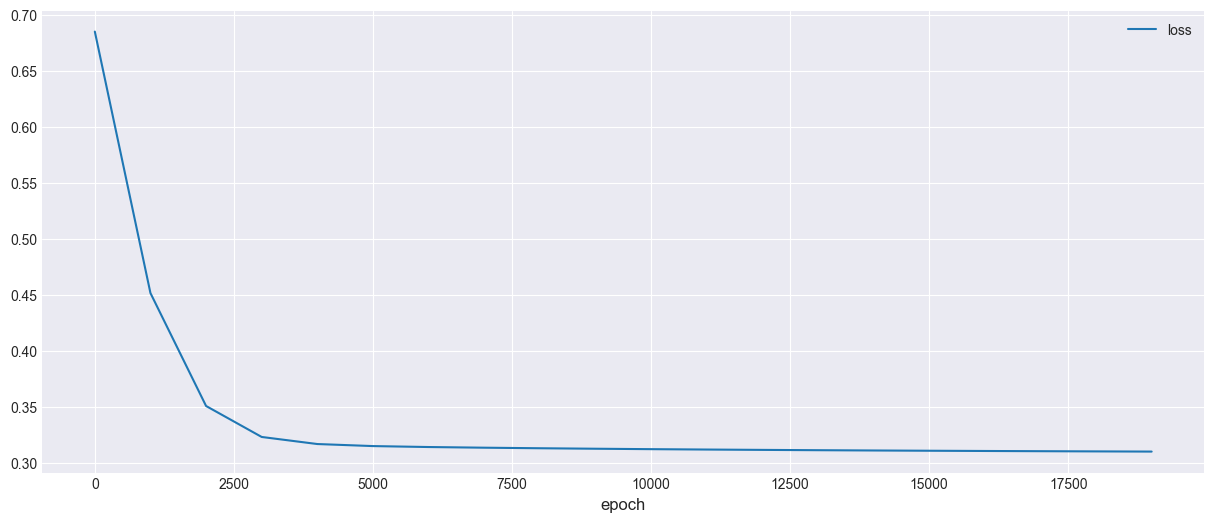

In [52]:
loss_df.plot(x = 'epoch', y = 'loss')
plt.show()